In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import pandas as pd
import numpy as np
import matplotlib.image as mpimg
import math

In [ ]:
def readFile(data_dir, size):
  data = pd.read_csv(data_dir, parse_dates=['Local time'], dayfirst=True)
  data = data.set_index('Local time')
  return data.head(size)

def drawGraph(data, column_names, x_axis, y_axis, title, interval, format, step):
    plt.figure(figsize=(15,7))

    for column_name in column_names:
        plt.plot(data.index, data[column_name], label=column_name)

    # Jei AMA yra vienas is stulpeliu, ji taip pat piesiame
    if 'AMA' in data.columns:
        plt.plot(data.index, data['AMA'], label='AMA', color='red')  # Pridedama AMA linija

    # Jei BB yra stulpeliuose, juos irgi piesiame
    for column_name in column_names:
      if column_name in ['Upper Band', 'Middle Band', 'Lower Band']:
        plt.plot(data.index, data[column_name], linestyle='--', linewidth=4)


    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    plt.title(title)
    plt.legend()
    plt.grid(color='green')

    plt.xlim(data.index[0], data.index[-1])
    plt.gca().xaxis.set_major_locator(interval)
    plt.gca().xaxis.set_major_formatter(format)

    # Apskaiciuojame min ir max reiksmes visiems stulpeliams, iskaitant AMA
    all_columns = column_names + ['AMA'] if 'AMA' in data.columns else column_names
    max_value = data[all_columns].max().max()
    min_value = data[all_columns].min().min()

    #np.arange(start, stop, step)
    plt.yticks(np.arange(math.floor(min_value), math.ceil(max_value), step=step))

    #automatinis x asies formatavimas
    plt.gcf().autofmt_xdate()
    plt.show()



def drawPriceAndMomentum(data, title):
    # Sukuriamas grafikas ir du subplotai su bendra x asimi, auksciu santykiai 2:1, bendras pavadinimas
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,7), sharex=True, gridspec_kw={'height_ratios': [2, 1]})
    fig.suptitle(title)

    # Nustatoma x asies (datos) formatavimas
    ax1.xaxis.set_major_locator(dates.DayLocator())
    ax1.xaxis.set_major_formatter(dates.DateFormatter('%m-%d'))

    # Virsutinis subplotas: Kainu grafikas
    ax1.plot(data.index, data['Close'], label='Close', color='tab:blue')
    ax1.set_ylabel('Close Price $')
    ax1.grid(True)
    ax1.legend()

    # Apatinis subplotas: Momentum indeksas
    ax2.plot(data.index, data['Momentum'], label='Momentum', color='tab:orange')
    ax2.set_ylabel('Momentum')
    ax2.grid(True)
    ax2.legend()

    # Automatinis datos formatavimas ir grafiko koregavimas
    fig.autofmt_xdate()
    fig.tight_layout()
    plt.show()



In [ ]:
#Adaptive Moving Average indeksas (slankusis vidurkis), parodo tikslesnę rinkos kainų tendencijos analizę,
# parodo kaip rinka juda aukštyn ar žemyn

def calculate_ama(data, n, fast, slow):

    # Absoliutus(modulis) kainos pokytis
    change = data.diff(n).abs()

    # Bendras kainos svyravimas per n dienu (rolling apjungia n elementus, suskirsto segmentais)
    volatility = data.diff().abs().rolling(n).sum()

    # Efektyvumo koeficientas (ER)
    er = change / volatility

    # Glaudinimo konstanta (SC)
    fast_sc = 2 / (fast + 1)
    slow_sc = 2 / (slow + 1)
    sc = (er * (fast_sc - slow_sc) + slow_sc) ** 2

    # AMA apskaiciavimas
    # Sukuriamas panda Series objektas, naudojamas saugoti ama reiksmes
    # Pradinio tasko nustatymas
    # Cikle atnaujinamos ama reiksmes, remiantis praeitomis reiksmemis
    ama = pd.Series(index=data.index, dtype=float)
    ama.iloc[n] = data.iloc[n]
    for i in range(n + 1, len(data)):
        ama.iloc[i] = ama.iloc[i - 1] + sc.iloc[i] * (data.iloc[i] - ama.iloc[i - 1]) #iloc yra pozicijos indeksavimas (integer location)

    return ama

#Bollinger bands indikatorius, skirtas irgi analizuoti rinkai, vidurine juosta rodo tendencijas, apatine - kainu svyravimo virsutine riba
# apatine juosta - kainu svyravimu apatine riba (paprastai 2 standartiniai nuokrypiai nuo vidurines linijos)

def calculate_bollinger_bands(data, n):

    #mean - aritmetinis vidurkis
    middle_band = data['Close'].rolling(window=n).mean()
    #standartinis nuokrypis
    std_dev = data['Close'].rolling(window=n).std()

    upper_band = middle_band + (std_dev * 2)
    lower_band = middle_band - (std_dev * 2)

    data['Middle Band'] = middle_band
    data['Upper Band'] = upper_band
    data['Lower Band'] = lower_band

    return data

# Momentum osciliatorius (is esmes tas pats kas indikatorius),
# naudojamas analizuoti rinku kainų pokyciu greiti arba jega per tam tikra laikotarpi.
# Momentum osciliatorius matuoja kainų skirtumą tarp dabartinio uždarymo kainos ir
# uždarymo kainos, kuri buvo prieš nustatytą laikotarpį atgal.

def calculate_momentum(data, n):

    momentum = data['Close'].diff(n)
    return momentum


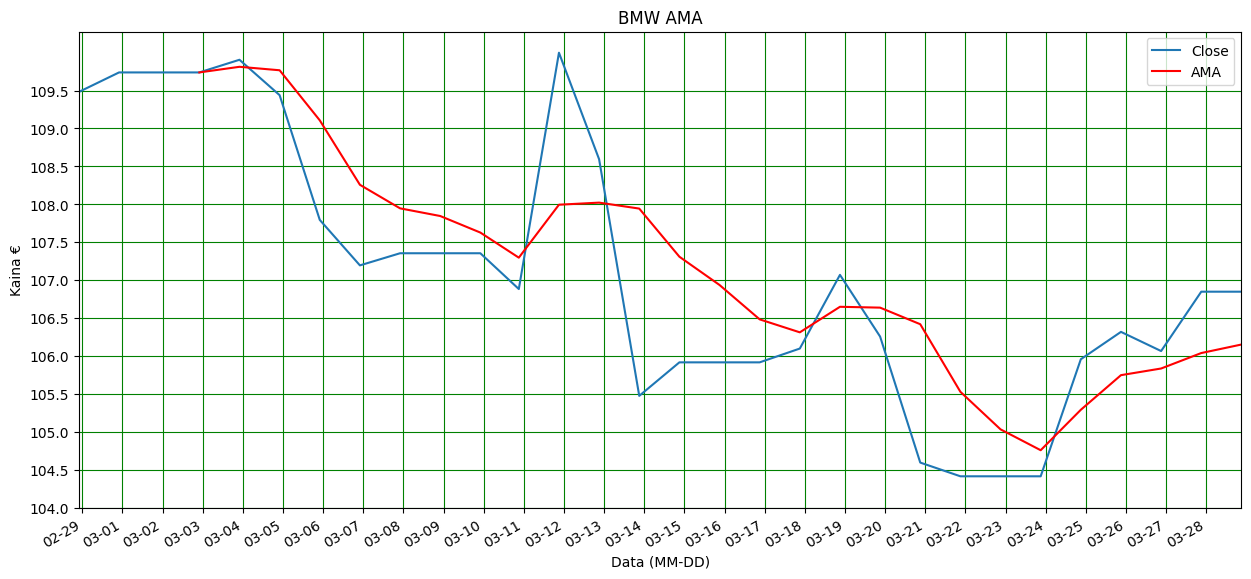

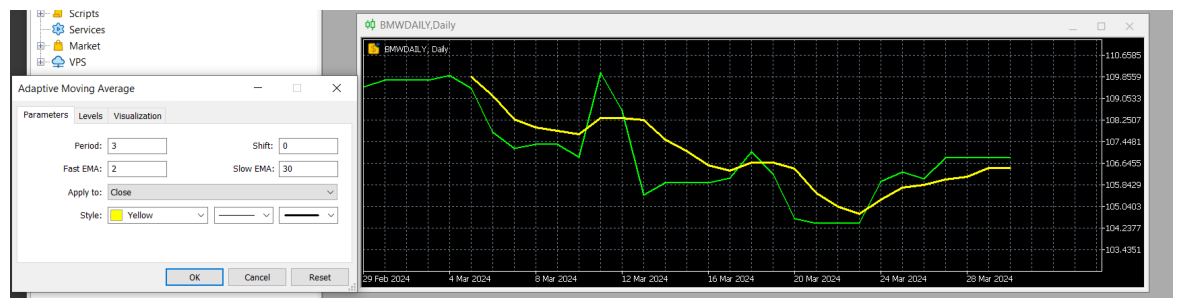

In [ ]:
data = readFile('day_bmw.csv', 30)
data['AMA'] = calculate_ama(data['Close'], n=3, fast=2, slow=30)


drawGraph(data=data,
          column_names=['Close'],
          x_axis='Data (MM-DD)',
          y_axis='Kaina €',
          title='BMW AMA',
          interval=dates.DayLocator(interval=1),
          format=dates.DateFormatter('%m-%d'),
          step=0.5)


print('\n')
img = mpimg.imread('AMA_bmw.png')
plt.figure(figsize=(15, 7))
plt.imshow(img)
plt.axis('off')
plt.show()

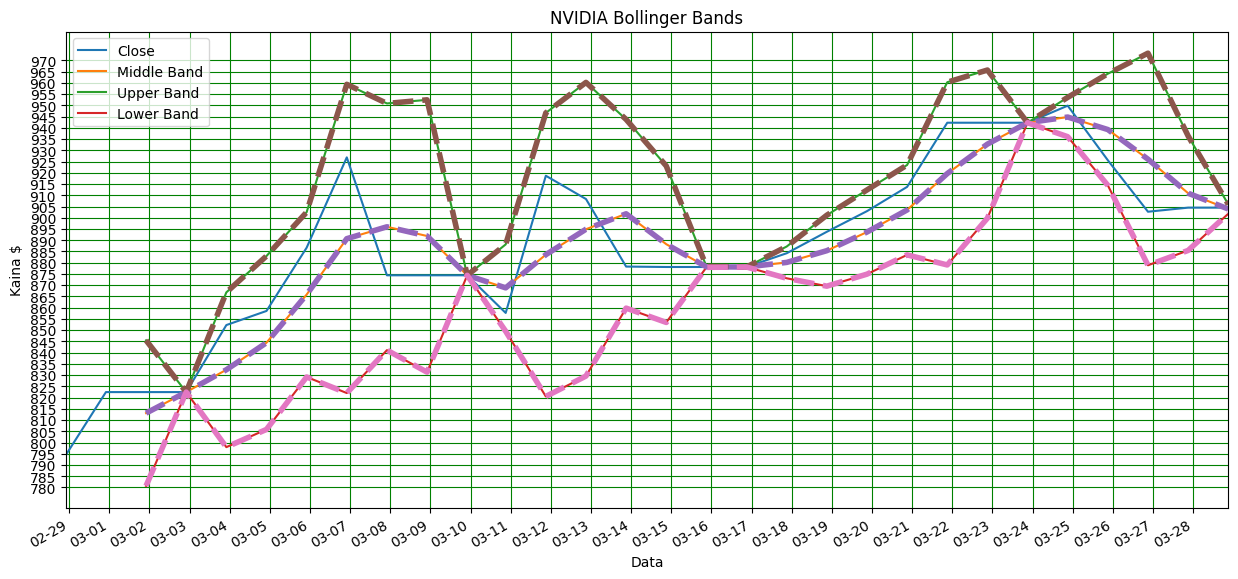

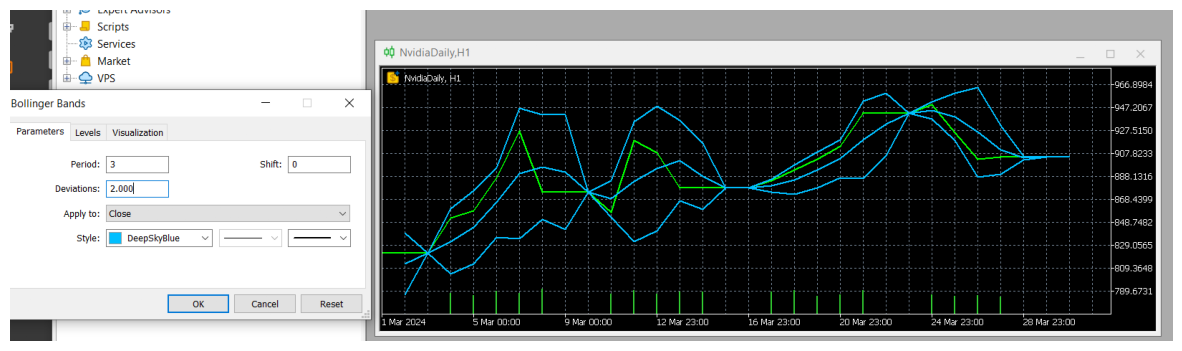

In [ ]:
data = readFile('day_nvidia.csv', 30)

data_bb = calculate_bollinger_bands(data, 3)

drawGraph(data=data_bb,
          column_names=['Close', 'Middle Band', 'Upper Band', 'Lower Band'],
          x_axis='Data',
          y_axis='Kaina $',
          title='NVIDIA Bollinger Bands',
          interval=dates.DayLocator(interval=1),
          format=dates.DateFormatter('%m-%d'),
          step=5)

print('\n')
img = mpimg.imread('BB_nvidia.png')
plt.figure(figsize=(15, 7))
plt.imshow(img)
plt.axis('off')
plt.show()

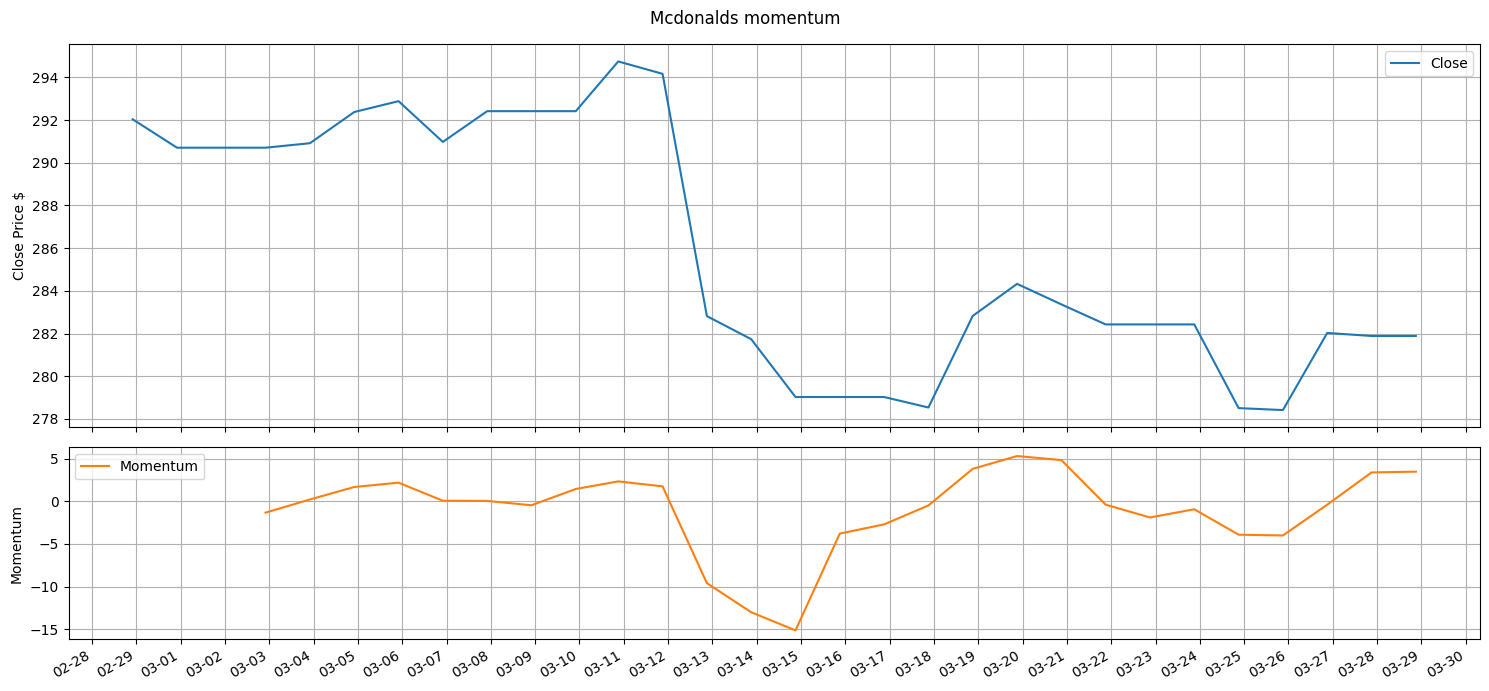

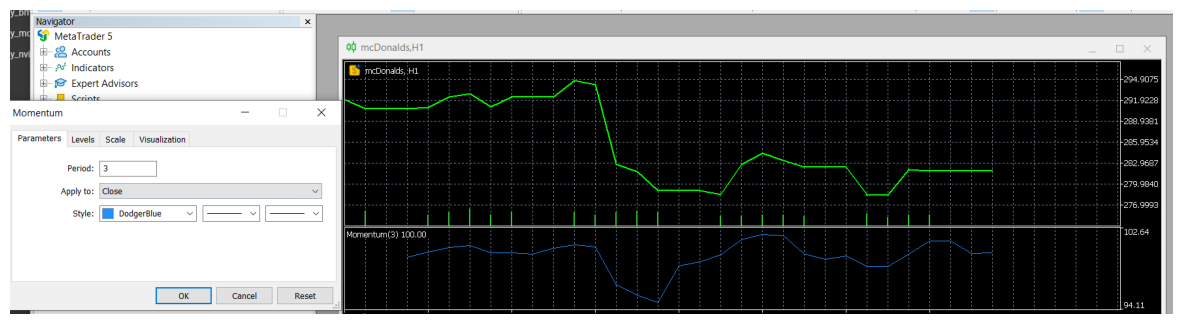

In [ ]:
data = readFile('day_mcdonalds.csv', 30)

data['Momentum'] = calculate_momentum(data, 3)

drawPriceAndMomentum(data,'Mcdonalds momentum')
print('\n')
img = mpimg.imread('Momentum_mcdonalds.png')
plt.figure(figsize=(15, 20))
plt.imshow(img)
plt.axis('off')
plt.show()


